In [ ]:
# To use louvain algorithm
!pip3 install python-louvain
# To use progressbar
!pip3 install progressbar2

In [1]:
import pandas as pd
import numpy as np
import math as m
import time 
from pycowview.data import csv_read_FA
from pycowview.manipulate import unique_cows
from pycowview.metrics import interaction_time
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import os
import community
from collections import defaultdict,Counter
import progressbar
import random
import itertools 
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import f1_score

In [2]:
# Weighted version!
# This function will get the path of each csv file
def findAllFile(base):
    for root, ds, fs in os.walk(base):
        for f in fs:
            if f.endswith('.csv'):
                fullname = os.path.join(root, f)
                yield fullname

# Input is the folders where the time matrix and cowlist are saved
# Output is a list which consists of 14 dictionaries
# The structure of dictionary:Cowlist,TimeMatrix,AajacencyMatrix_binary,Unweighted_Graph
def time_matrix_to_graph(tm_folder,cl_folder):
    dict_list = []
    i = 0
    tmlist = list(findAllFile(tm_folder))
    tmlist.sort()
    cllist = list(findAllFile(cl_folder))
    cllist.sort()
    for tm,cl in zip(tmlist,cllist):
        # print(tm,cl)
        # Get the path of csv
        # get cowlist
        cowlist = np.loadtxt(cl,delimiter=",").astype(int)
        # load original time matrix from csv and process it to be an adjacency Matrix
        OM = np.asmatrix(np.loadtxt(tm,delimiter=","))
        
        # Get unweighted adjacency matrix(binary)
        # init adjacency matrix
        #AM = np.zeros((OM.shape))
        # set the threshold to be 30 minutes(1800 seconds)
        #epsilon = 1800
        # just consider if there is an edge between two cows, the edge is unweighted
        #AM[OM >= epsilon] = 1
        #AM[OM < epsilon] = 0 
        #np.fill_diagonal(AM,0)
        # Get graph from AM, no-direct and no-weight graph
        #G_AM_temp = nx.from_numpy_matrix(AM,parallel_edges=False,create_using = nx.Graph())
        
        # Get weighted adjacency matrix
        # load original matrix from csv and process it to be an adjacency Matrix
        AM = np.zeros((OM.shape))
        # set the threshold to be 30 minutes(1800 seconds)
        epsilon = 1800
        # consider if there is an edge between two cows, the edge is weighted
        maxnr=np.amax(OM)
        AM=np.where(OM<=epsilon,0,(OM-epsilon)/(maxnr-epsilon))
        np.fill_diagonal(AM,0)
        # Get graph from AM, no-direct and weighted graph
        G_AM_temp = nx.from_numpy_matrix(AM,parallel_edges=False,create_using = nx.Graph())
        
        # Make sure the order of cowlist is the same as the row name!
        print('Shape of matrix:',AM.shape)
        print('number of nodes in graph',len(G_AM_temp),'length of cowlist',len(cowlist))
        mapping = dict(zip(G_AM_temp, cowlist))
        #print(mapping)
        # Rename the nodes
        G_AM = nx.relabel_nodes(G_AM_temp, mapping)
        
        # Get the dict of the collection(CL,TM,AM_weighted,Graph)
        data_dict = dict(CL=cowlist,TM=OM,AM_weighted=AM,Graph=G_AM)
        print('Document No.',i)
        print('TM path:',tm,'CL path:',cl)
        i = i + 1
        dict_list.append(data_dict)

    print('The length of the list: ',len(dict_list))
    return dict_list

In [17]:
def community_Louvain(i,G):
    #print('This is the result of day %d'%(i+1))
    
    # Remove the nodes whose degree is zero
    nodes_removed = [node for node,degree in dict(G.degree()).items() if degree == 0]
    G.remove_nodes_from(nodes_removed)
    #print(len(nodes_removed),'nodes whose degree is zero are removed')
    
    # Louvain algorithm
    partition = community.best_partition(G,weight = 'weight',randomize=False)
    if (len(partition.values())==0):
        return 0,0,0
    num_communities = max(partition.values())
    
    # create a dict object:{community1:[nodelist],community2:[nodelist],......}
    # community1:[nodelist] is a tuple
    communities_Louvain = defaultdict(list) 
    for k, v in partition.items():
        communities_Louvain[v].append(k)    
    np.save('./community/Louvain_weighted/Day_%d_Louvain_weighted_communities.npy'%(i+1), communities_Louvain)
    
    #read the dict from file
    #communities_Louvain = np.load('./community/Louvain/Day_%d_Louvain_Unweighted_communities.npy', allow_pickle='TRUE')
    #print(communities_Louvain)

    num_communities = max(partition.values())
    len_Louvain = len(communities_Louvain)
    #print('max No. of community:',num_communities)
    print('num of communities:',len_Louvain)
    print('Modularity:',nx.algorithms.community.quality.modularity(G,communities_Louvain.values()))

    # Colormap for plotting
    color_Louvain = 0
    random.seed(7)
    total_colors = list(mpl.colors.get_named_colors_mapping())
    total_colors.remove('black')
    color_map_Louvain = random.sample(total_colors,len_Louvain)

    # Plot the figure
    plt.figure(figsize=(20, 20))  # image size
    pos = nx.fruchterman_reingold_layout(G, scale = 1) # position of nodes
    degree_dict = dict(G.degree())
    nx.draw_networkx(G, pos, node_size=5,width=0.05, alpha=1, with_labels=False)
    for community_Louvain in communities_Louvain.items():
        
        node_list = community_Louvain[1]
        edge_list = list(itertools.chain.from_iterable([list(G.edges(node)) for node in node_list]))
        label_list = {}
        for node in node_list:
            #set the node name as the key and the label as its value 
            label_list[node] = node 
        community_degree_dict = {key: value for key, value in degree_dict.items() if key in node_list}
        node_size_list = [d*40 for d in community_degree_dict.values()]
        
        nx.draw_networkx_nodes(G, pos , nodelist = node_list, node_size = node_size_list, node_color = color_map_Louvain[color_Louvain],alpha = 0.7)
        nx.draw_networkx_edges(G, pos , edgelist = edge_list, edge_color = color_map_Louvain[color_Louvain],alpha = 0.5)
        nx.draw_networkx_labels(G, pos, label_list, font_size = 16, font_color = 'black',alpha = 0.5)
        color_Louvain += 1
    plt.savefig('./community/Louvain_weighted/Day%d_weighted_Community.png'%(i+1))
    #plt.show()
    
    return nodes_removed, communities_Louvain, partition

In [5]:
def compute_NMI(p1,p2):
    list1 = []
    list2 = []
    dict1 = {}
    dict2 = {}
    key1set = set(sorted(p1))
    key2set = set(sorted(p2))
    keylist = list(key1set&key2set)
    keylist.sort()
    #print(len(key1set))
    #print(len(key2set))
    #print(len(keylist))
    i = 0
    for key in keylist:
        list1.append(p1.get(key,-1))
        list2.append(p2.get(key,-1))
        dict1[key] = p1.get(key,-1)
        dict2[key] = p2.get(key,-1)
        #i = i+1
        #print(i,key)
    #print(list1)
    #print(list2)
    return normalized_mutual_info_score(list1,list2), adjusted_mutual_info_score(list1,list2), f1_score(list1,list2, average='weighted')

In [6]:
def create_rand_adjacency(day):
    # create a random adjacency matrix of a specific day
    # compute the density
    graph = data_dict_list[day-1].get('Graph')
    density = nx.classes.function.density(graph)
    # create a basic matrix has the density
    AM = data_dict_list[day-1].get('AM_weighted')
    AM_rand = np.random.rand(AM.shape[0]*AM.shape[1]).reshape((AM.shape))
    AM_temp = np.zeros((AM_rand.shape))
    AM_temp[AM_rand <= density] = 1
    AM_temp[AM_rand > density] = 0

    # unweighted
    AM_up = np.triu(AM_temp)
    np.fill_diagonal(AM_up,0)
    AM_unweighted_rand = AM_up + AM_up.T

    # weighted
    AM_weighted_up = np.zeros((AM_up.shape))
    row,col = np.where(AM_up == 1)
    for i,j in zip(row,col):
        if AM_up[i][j] == 1:
            AM_weighted_up[i][j] = np.random.rand(1)
        else:
            pass
    AM_weighted_rand = AM_weighted_up + AM_weighted_up.T
    
    return AM_unweighted_rand, AM_weighted_rand 

In [7]:
# This part is used to process the time matrices
tm_folder = './area_divided_time_matrix/Time in general area'
cl_folder = './cow_list'
data_dict_list = time_matrix_to_graph(tm_folder,cl_folder)

Shape of matrix: (213, 213)
number of nodes in graph 213 length of cowlist 213
Document No. 0
TM path: ./area_divided_time_matrix/Time in general area\Time_General_FA_20201016T000000UTC.csv CL path: ./cow_list\Cow_list_20201016T000000UTC.csv
Shape of matrix: (212, 212)
number of nodes in graph 212 length of cowlist 212
Document No. 1
TM path: ./area_divided_time_matrix/Time in general area\Time_General_FA_20201017T000000UTC.csv CL path: ./cow_list\Cow_list_20201017T000000UTC.csv
Shape of matrix: (219, 219)
number of nodes in graph 219 length of cowlist 219
Document No. 2
TM path: ./area_divided_time_matrix/Time in general area\Time_General_FA_20201018T000000UTC.csv CL path: ./cow_list\Cow_list_20201018T000000UTC.csv
Shape of matrix: (208, 208)
number of nodes in graph 208 length of cowlist 208
Document No. 3
TM path: ./area_divided_time_matrix/Time in general area\Time_General_FA_20201019T000000UTC.csv CL path: ./cow_list\Cow_list_20201019T000000UTC.csv
Shape of matrix: (209, 209)
numb

  0% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

num of communities: 18
Modularity: 0.7255791193876857


  7% (1 of 14) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:07

num of communities: 19
Modularity: 0.775542970339383


 14% (2 of 14) |###                      | Elapsed Time: 0:00:01 ETA:   0:00:07

num of communities: 17
Modularity: 0.7762893823873938


 21% (3 of 14) |#####                    | Elapsed Time: 0:00:01 ETA:   0:00:06

num of communities: 22
Modularity: 0.7940482327440997


 28% (4 of 14) |#######                  | Elapsed Time: 0:00:02 ETA:   0:00:06

num of communities: 20
Modularity: 0.7947601291124431


 35% (5 of 14) |########                 | Elapsed Time: 0:00:03 ETA:   0:00:05

num of communities: 19
Modularity: 0.8187963283525904


 42% (6 of 14) |##########               | Elapsed Time: 0:00:03 ETA:   0:00:05

num of communities: 23
Modularity: 0.8474668865107247


 50% (7 of 14) |############             | Elapsed Time: 0:00:04 ETA:   0:00:04

num of communities: 22
Modularity: 0.8072683138503265


 57% (8 of 14) |##############           | Elapsed Time: 0:00:04 ETA:   0:00:03

num of communities: 23
Modularity: 0.7853466482649594


 64% (9 of 14) |################         | Elapsed Time: 0:00:05 ETA:   0:00:03

num of communities: 21
Modularity: 0.759416122269512


 71% (10 of 14) |#################       | Elapsed Time: 0:00:06 ETA:   0:00:02

num of communities: 20
Modularity: 0.8115631310032807


 78% (11 of 14) |##################      | Elapsed Time: 0:00:06 ETA:   0:00:01

num of communities: 22
Modularity: 0.7679011991402483


 85% (12 of 14) |####################    | Elapsed Time: 0:00:07 ETA:   0:00:01

num of communities: 19
Modularity: 0.7711884459607129


 92% (13 of 14) |######################  | Elapsed Time: 0:00:07 ETA:   0:00:00

num of communities: 17
Modularity: 0.7296765296612676


100% (14 of 14) |########################| Elapsed Time: 0:00:08 Time:  0:00:08


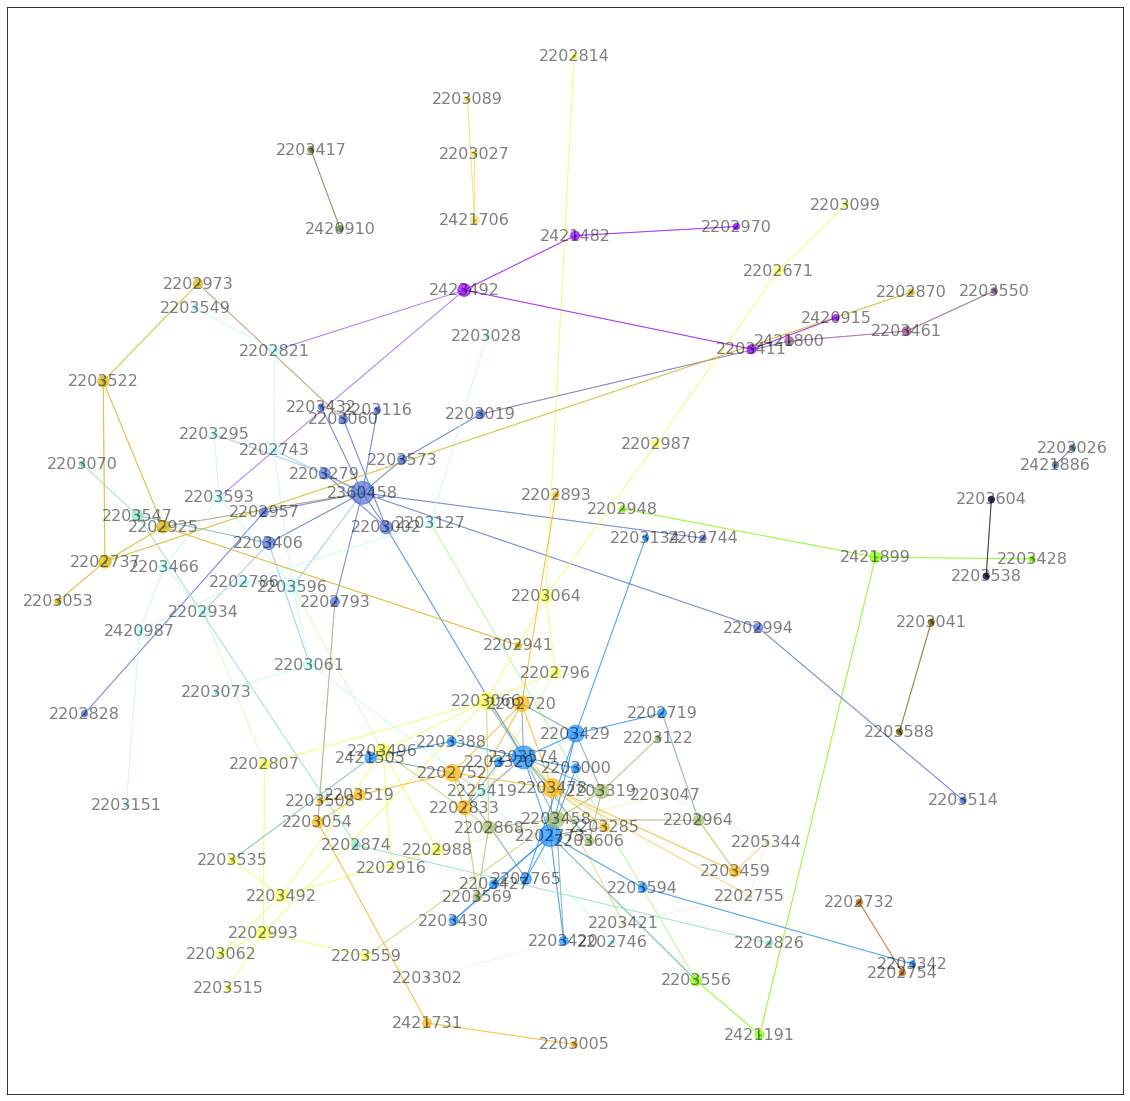

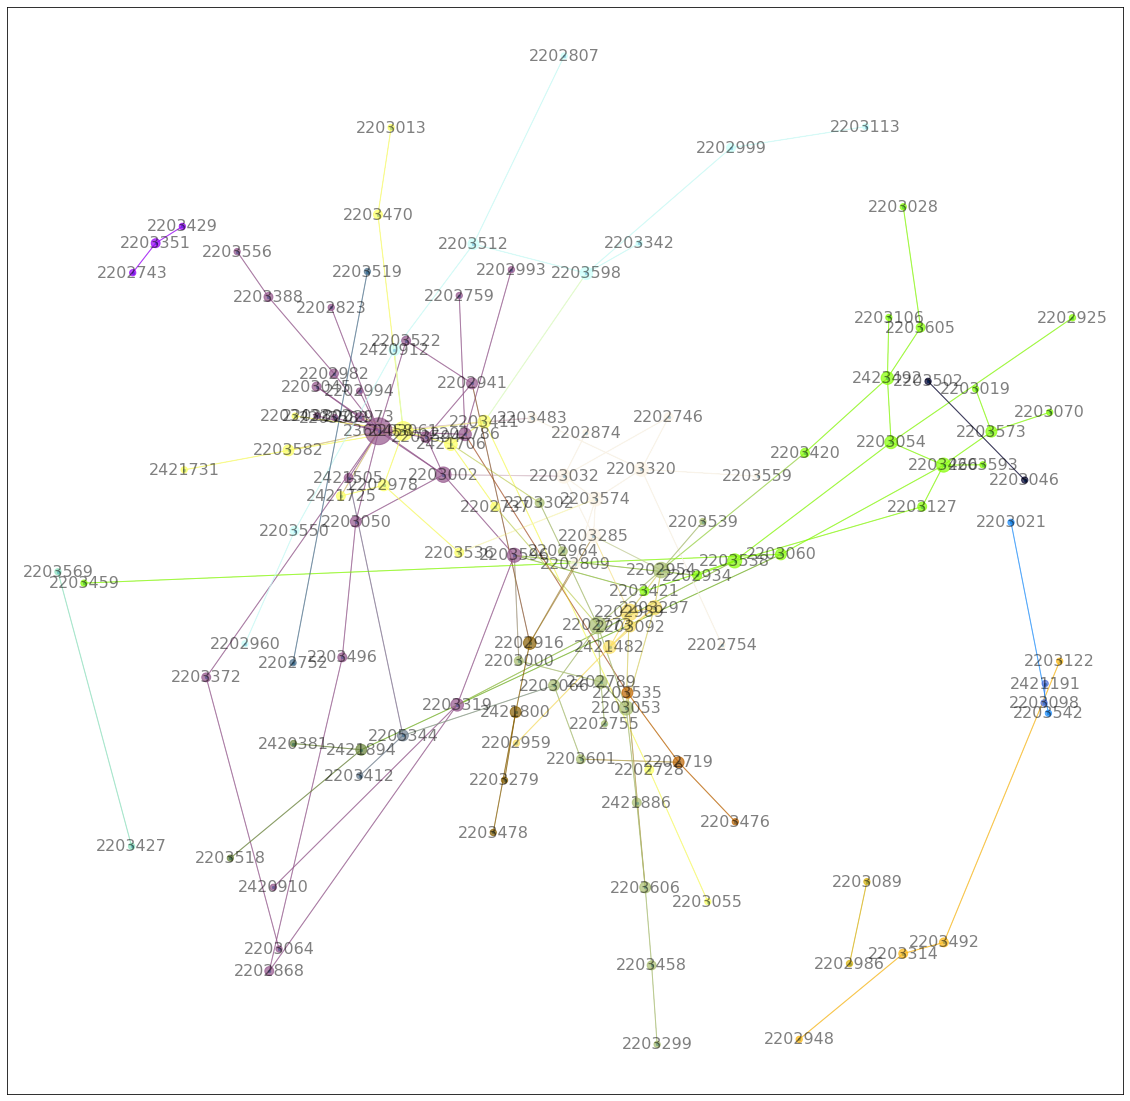

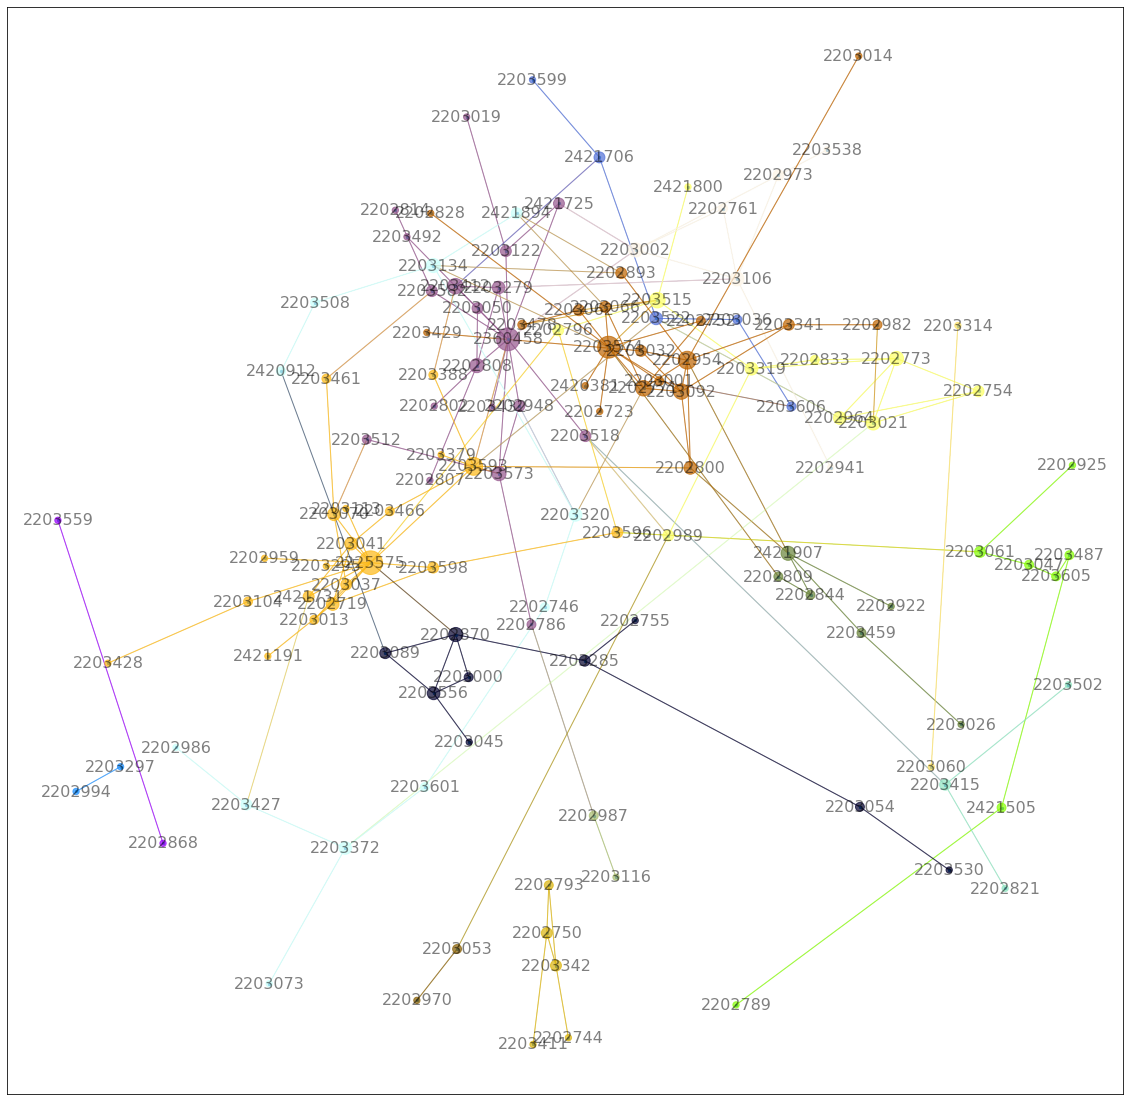

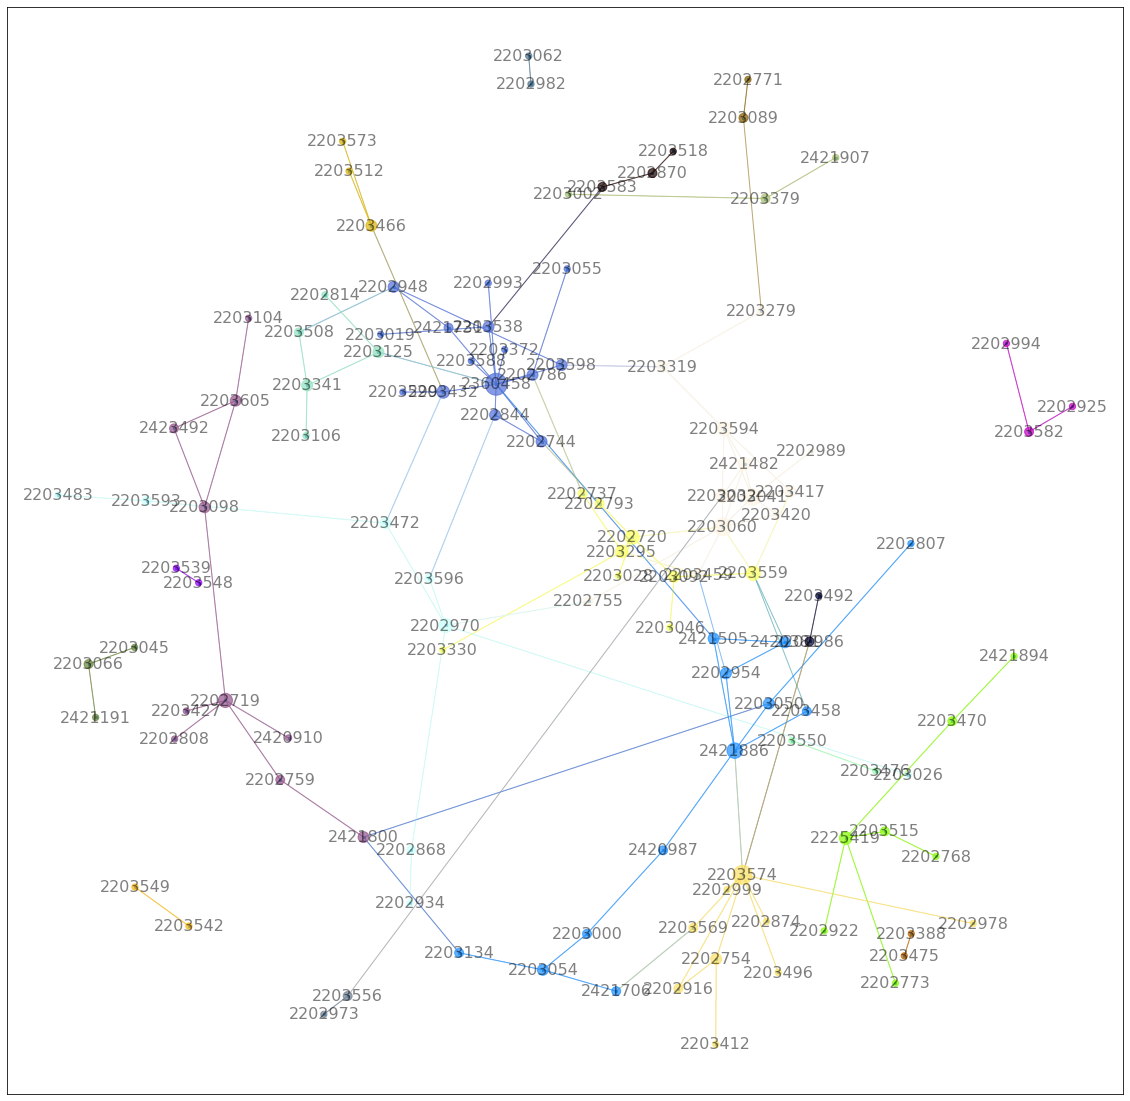

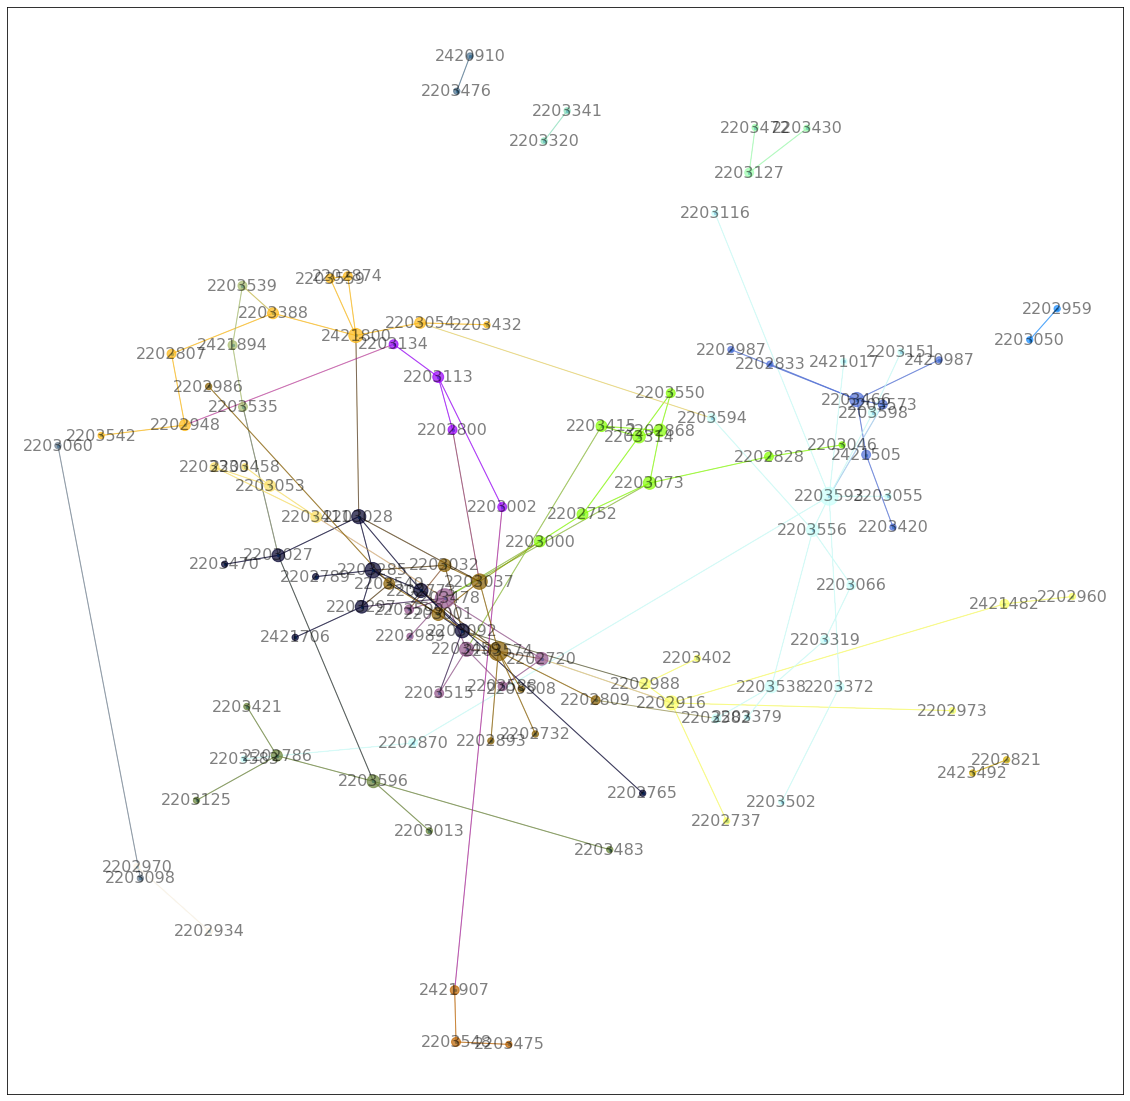

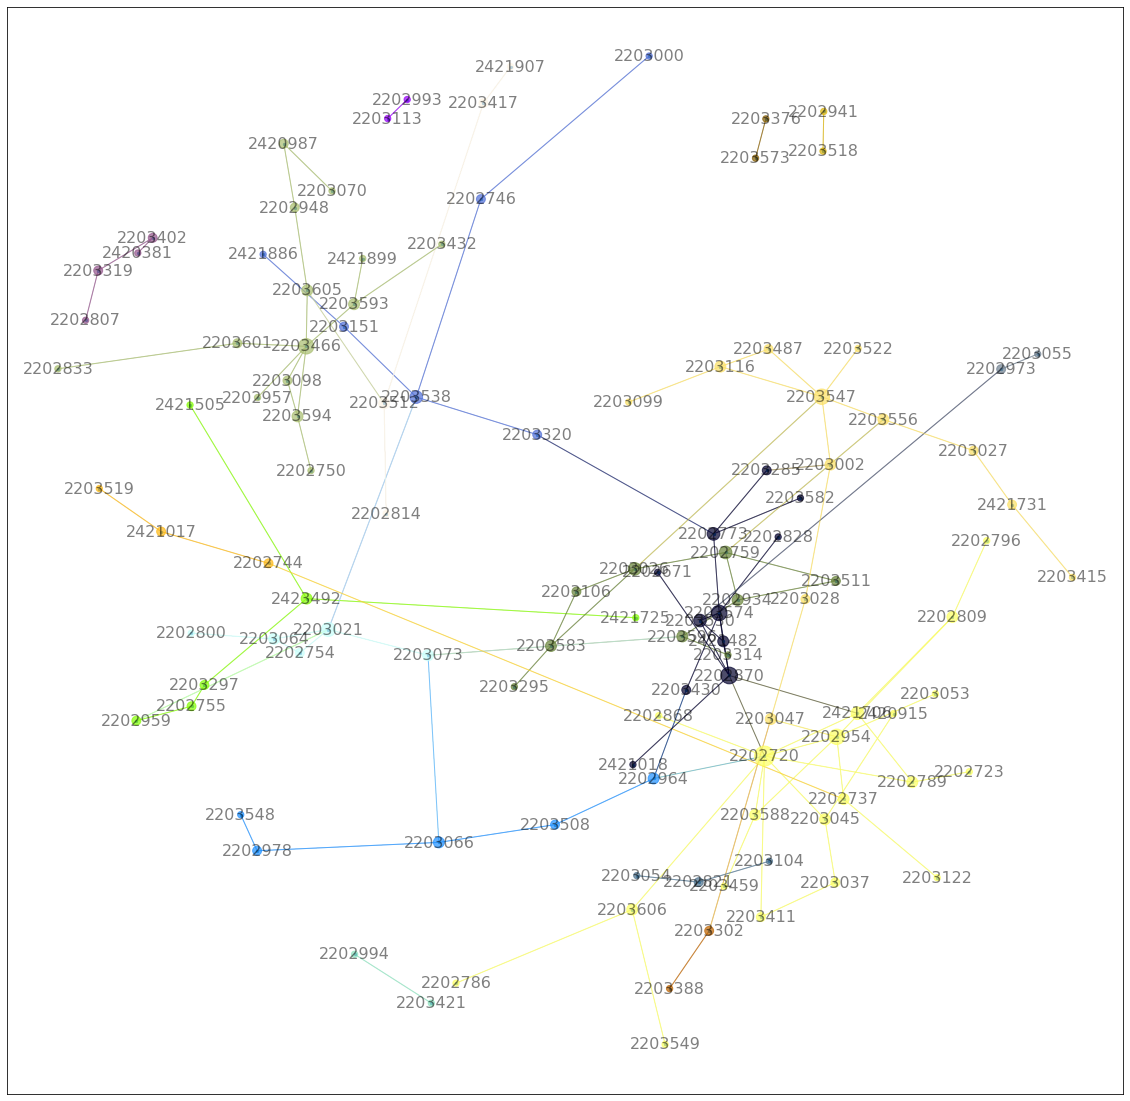

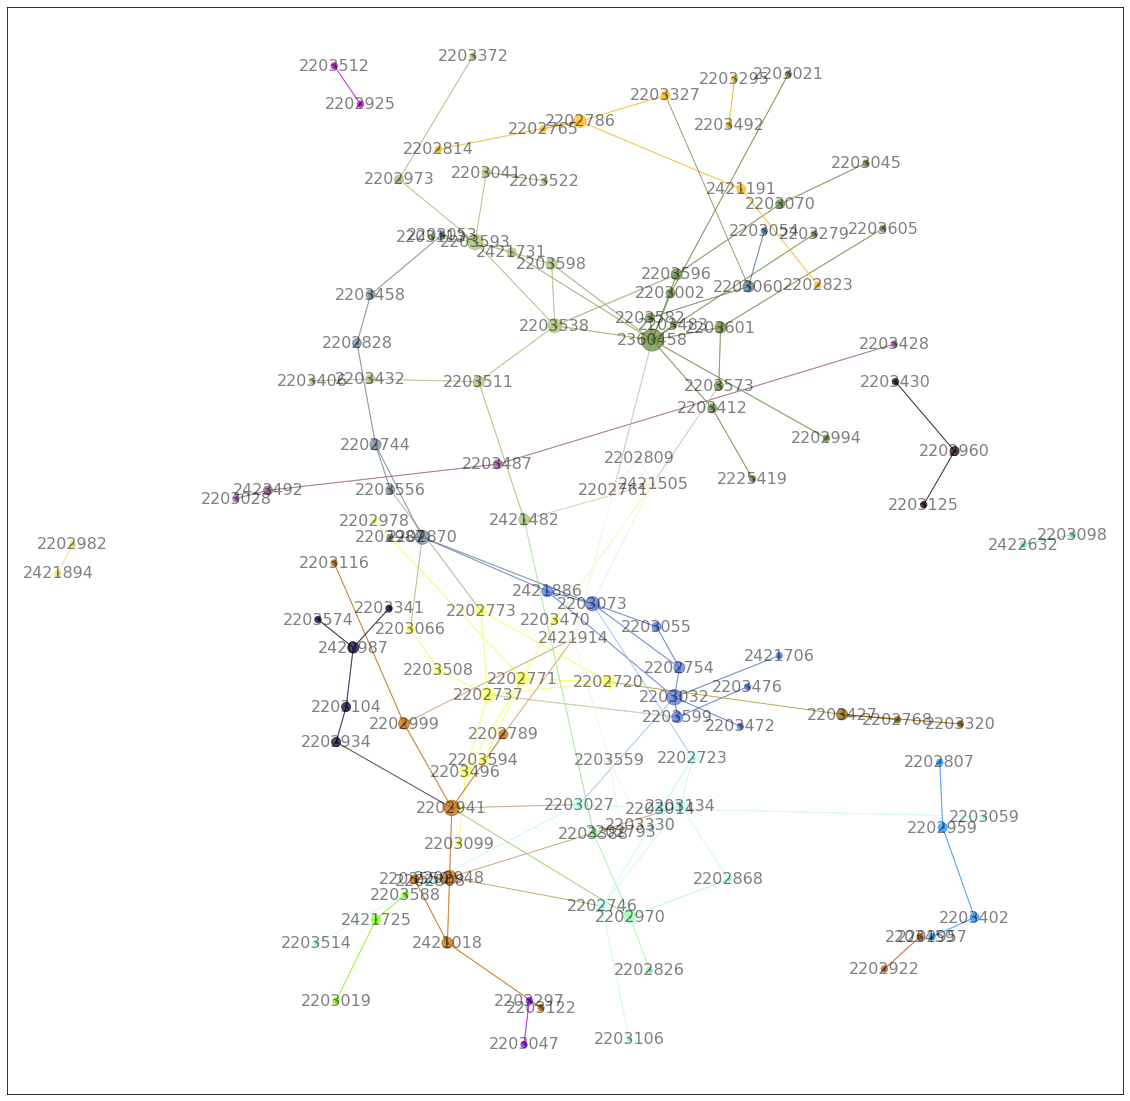

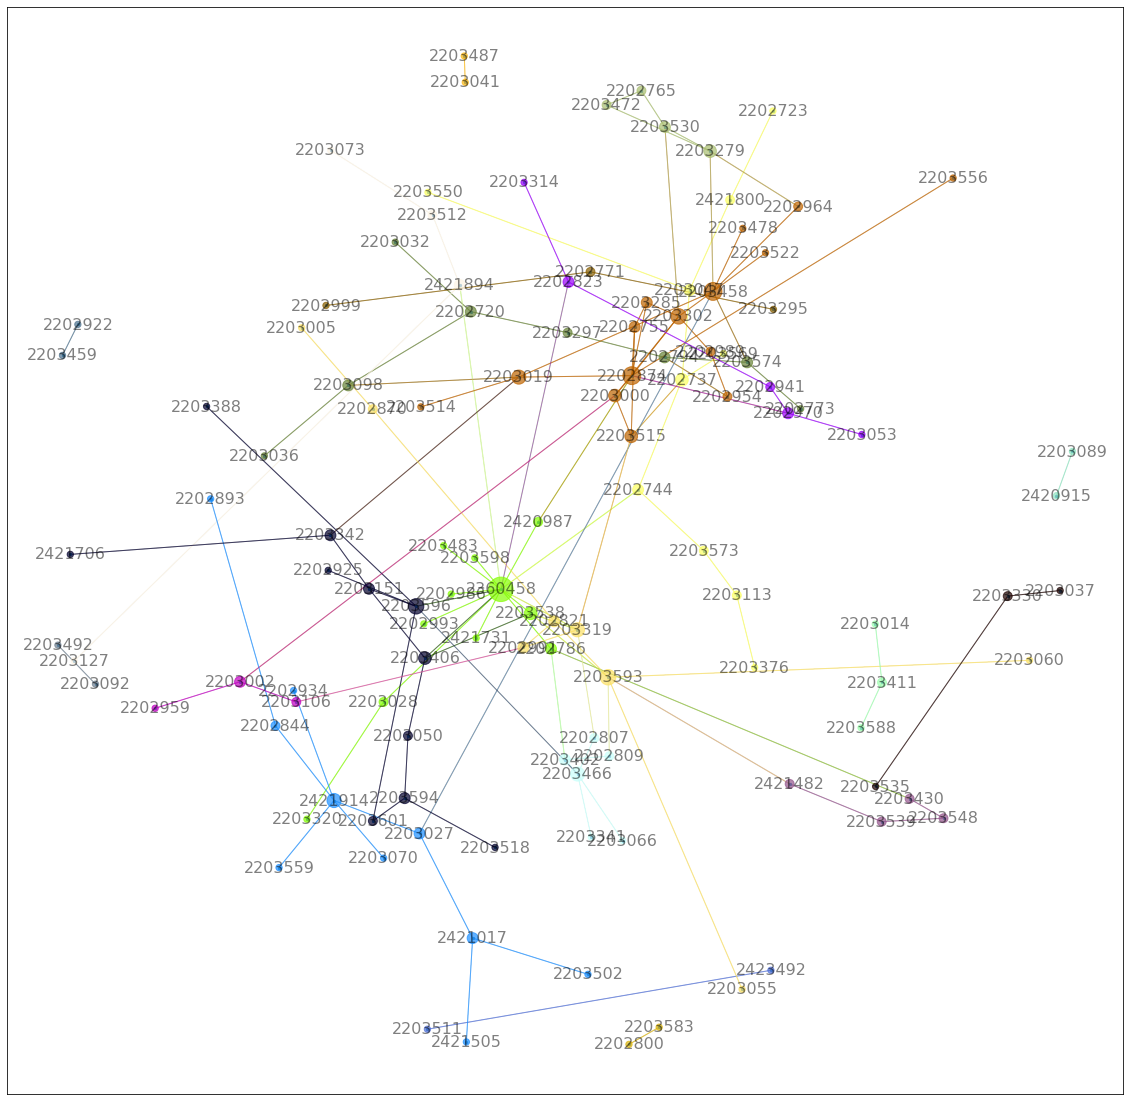

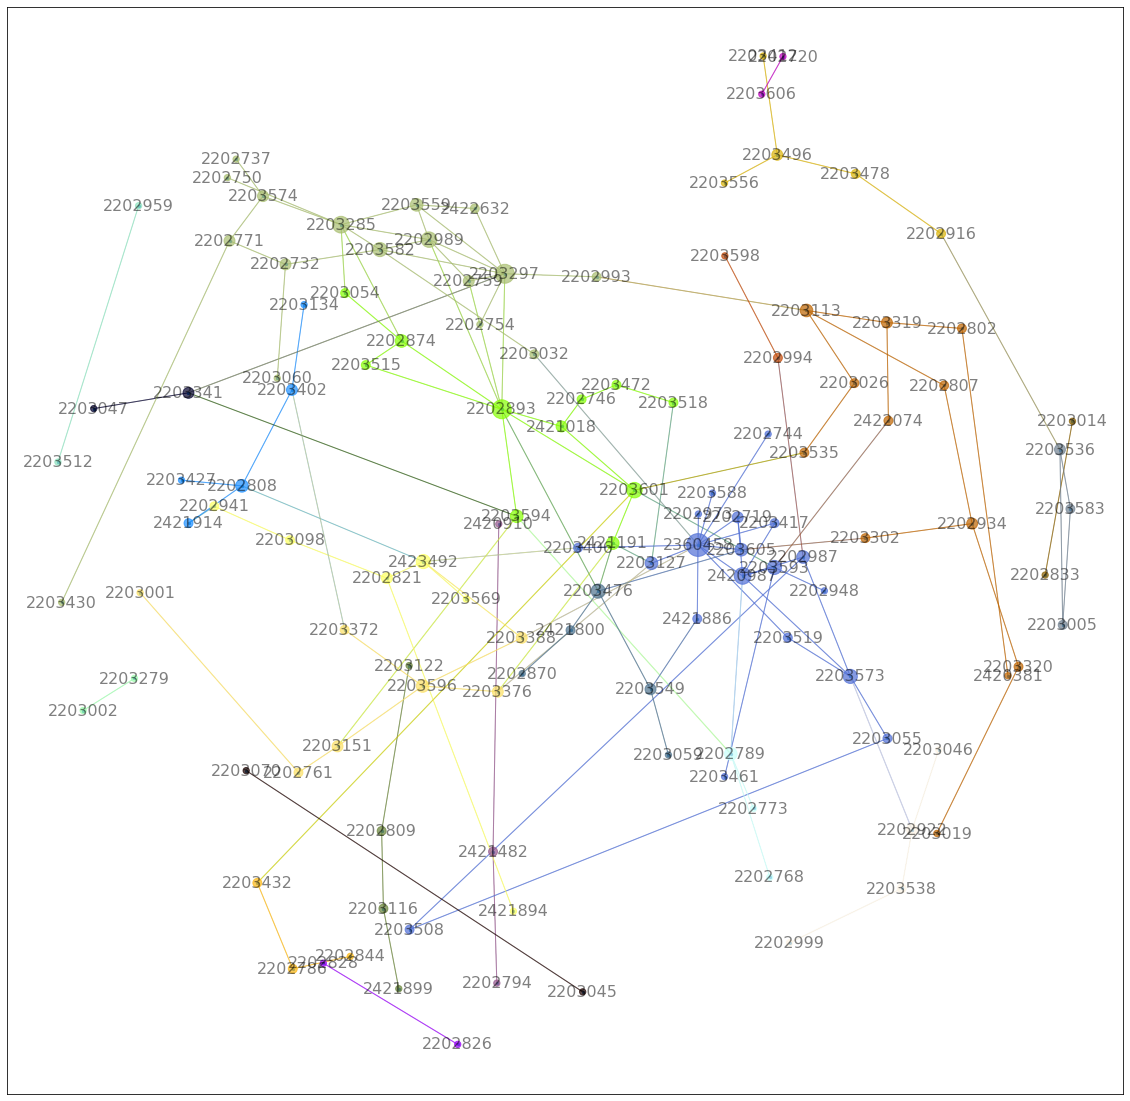

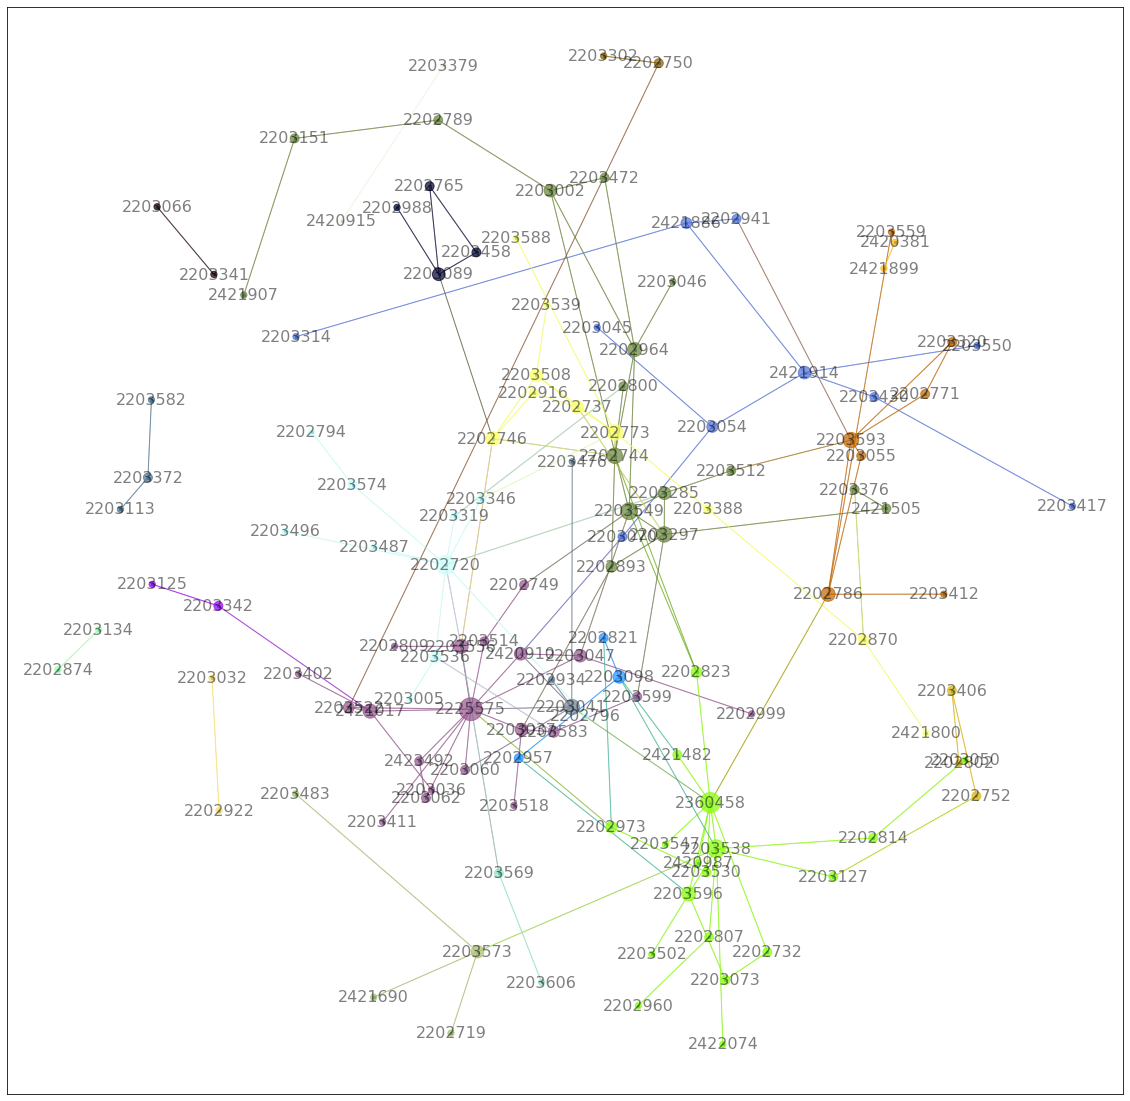

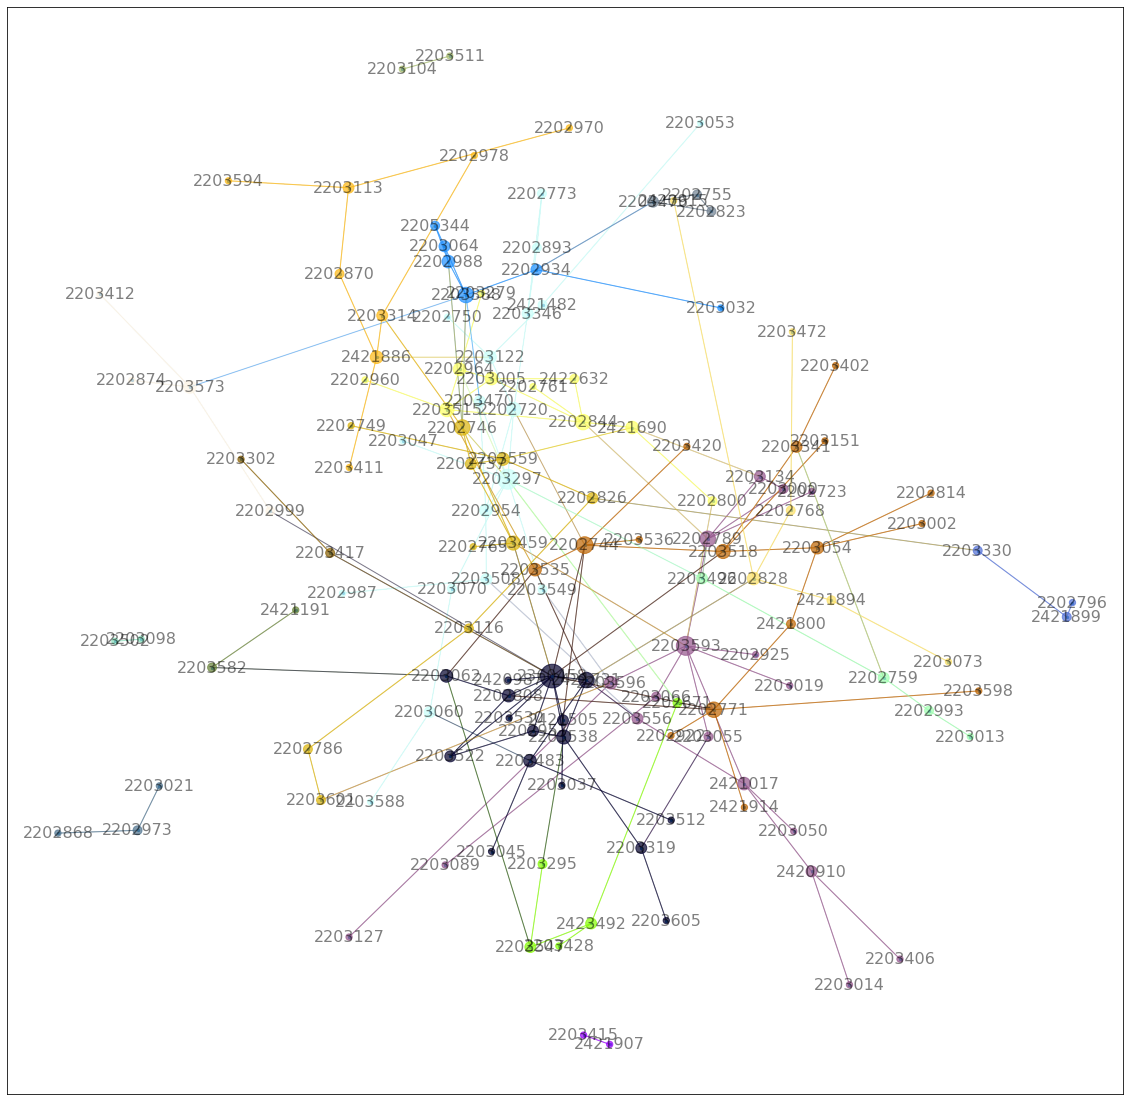

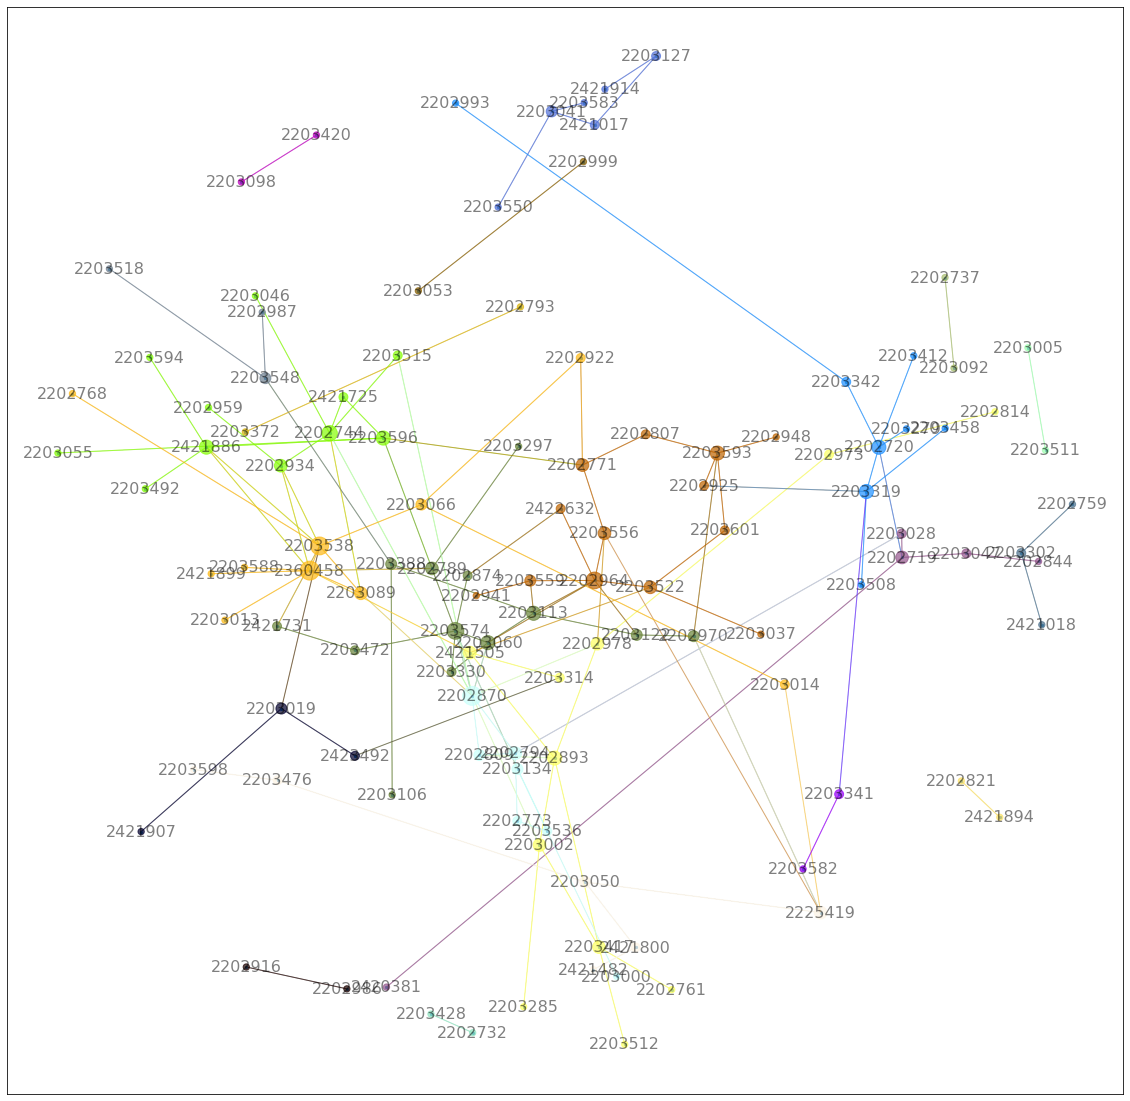

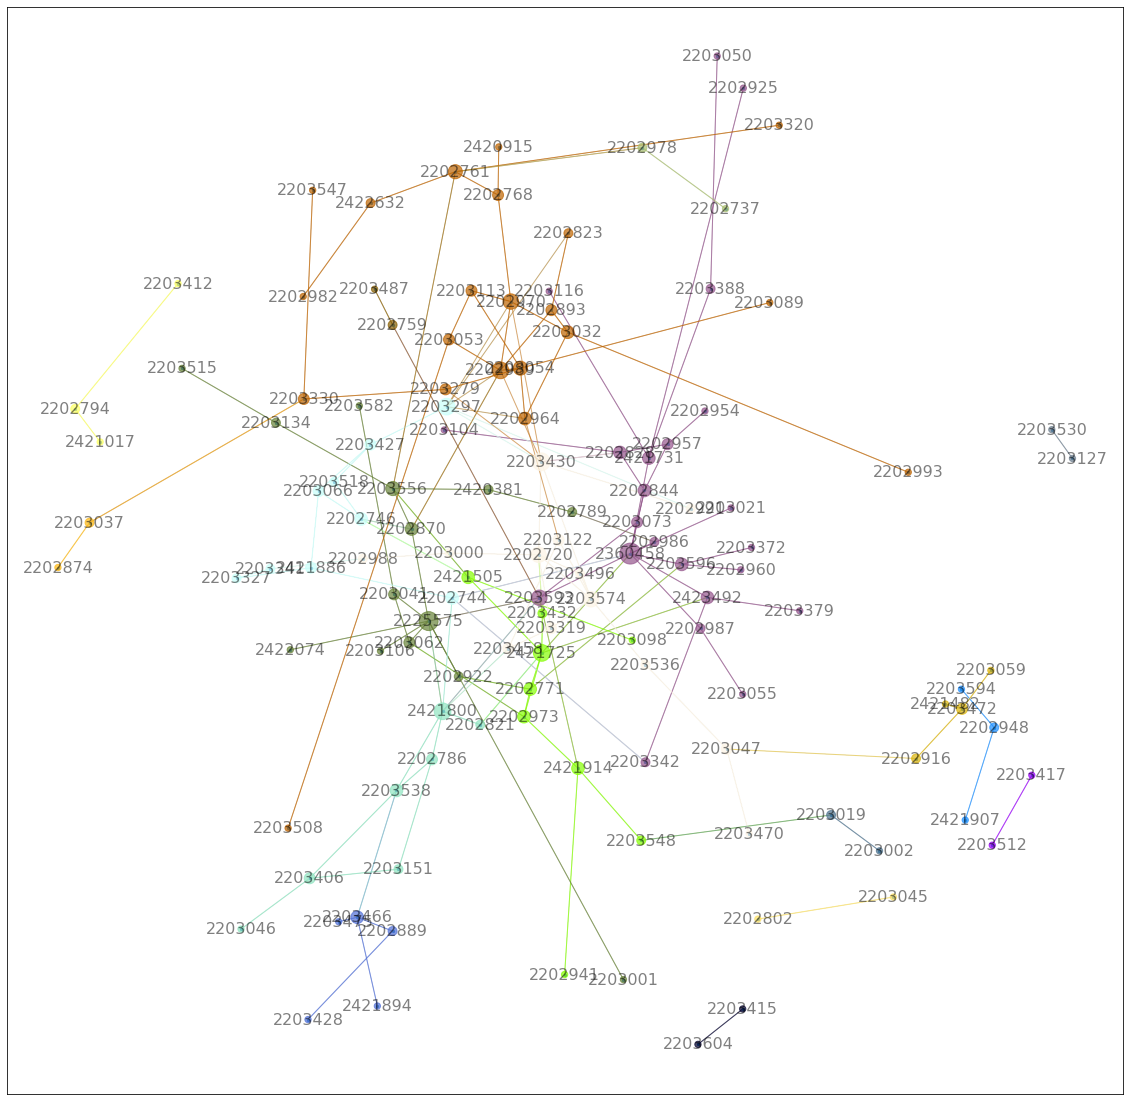

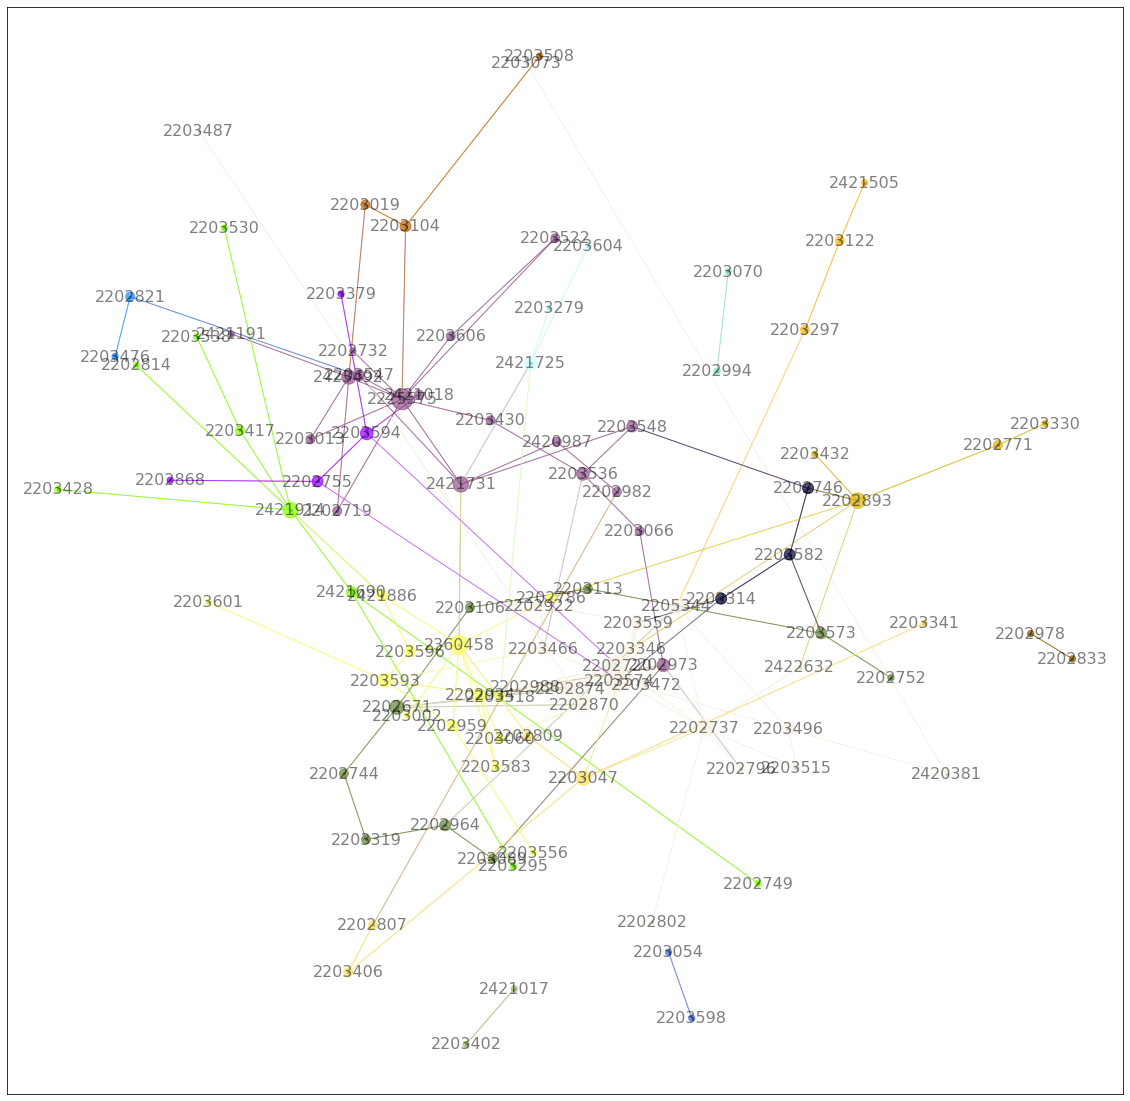

In [18]:
# Louvain algorithm
partition_14days = []
Louvain_community_14days = []
nodes_removed_14days = []
bar = progressbar.ProgressBar()
# from 0 to 13
for i in bar(range(0,len(data_dict_list))):
    nodes_removed_1day, Louvain_community_1day, partition_1day = community_Louvain(i,data_dict_list[i].get('Graph'))
    nodes_removed_14days.append(nodes_removed_1day)
    Louvain_community_14days.append(Louvain_community_1day)
    partition_14days.append(partition_1day)

In [ ]:
#real day j vs real day j+1
bar = progressbar.ProgressBar()
print('Weighted graph(Louvain)')
for j in bar(range(1,len(data_dict_list))):
    print('Real Day %d and Real Day %d :NMI is'%(j,j+1),compute_NMI(partition_14days[j-1],partition_14days[0]))

# Draft

In [ ]:
G1 = nx.karate_club_graph()
G2 = nx.karate_club_graph()
n1,l1,p1=community_Louvain(1,G1)
n2,l2,p2=community_Louvain(1,G2)
compute_NMI(p1,p2)

In [ ]:
# random graph of day 
uwr,wr = create_rand_adjacency(6)
# Get graph from AM, no-direct and weighted graph
G_AM_temp = nx.from_numpy_matrix(wr,parallel_edges=False,create_using = nx.Graph())
cowlist = data_dict_list[5].get('CL')
# Make sure the order of cowlist is the same as the row name!
print('Shape of matrix:',wr.shape)
print('number of nodes in graph',len(G_AM_temp),'length of cowlist',len(cowlist))
mapping = dict(zip(G_AM_temp, cowlist))
#print(mapping)
# Rename the nodes
G_AM = nx.relabel_nodes(G_AM_temp, mapping)
nodes_removed_1day_r, Louvain_community_1day_r, partition_1day_r = community_Louvain(5,G_AM)

In [ ]:
# The NMI of real day1 and real day2
list1 = []
list2 = []
key1set = set(sorted(partition_14days[0]))
key2set = set(sorted(partition_14days[1]))
keylist = list(key1set&key2set)
print(len(key1set))
print(len(key2set))
print(len(keylist))
keylist.sort()
i = 0
for key in keylist:
    list1.append(partition_14days[0].get(key,-1))
    list2.append(partition_14days[1].get(key,-1))
    #i = i+1
    #print(i,key)
#print(list1)
#print(list2)
normalized_mutual_info_score(list1,list2)

In [ ]:
# The NMI of real day1 and random day1
list1 = []
list2 = []
key1set = set(sorted(partition_14days[0]))
key2set = set(sorted(partition_1day_r))
keylist = list(key1set&key2set)
print(len(key1set))
print(len(key2set))
print(len(keylist))
keylist.sort()
i = 0
for key in keylist:
    list1.append(partition_14days[0].get(key,-1))
    list2.append(partition_1day_r.get(key,-1))
    #i = i+1
    #print(i,key)
#print(list1)
#print(list2)
normalized_mutual_info_score(list1,list2)

In [ ]:
# The NMI of real day2 and random day1
list1 = []
list2 = []
key1set = set(sorted(partition_14days[1]))
key2set = set(sorted(partition_1day_r))
keylist = list(key1set&key2set)
print(len(key1set))
print(len(key2set))
print(len(keylist))
keylist.sort()
i = 0
for key in keylist:
    list1.append(partition_14days[1].get(key,-1))
    list2.append(partition_1day_r.get(key,-1))
    #i = i+1
    #print(i,key)
#print(list1)
#print(list2)
normalized_mutual_info_score(list1,list2)

In [ ]:
# random graph of day 13
uwr13,wr13 = create_rand_adjacency(13)
# Get graph from AM, no-direct and weighted graph
G_AM_temp = nx.from_numpy_matrix(wr13,parallel_edges=False,create_using = nx.Graph())
cowlist = data_dict_list[12].get('CL')
# Make sure the order of cowlist is the same as the row name!
print('Shape of matrix:',wr13.shape)
print('number of nodes in graph',len(G_AM_temp),'length of cowlist',len(cowlist))
mapping = dict(zip(G_AM_temp, cowlist))
#print(mapping)
# Rename the nodes
G_AM = nx.relabel_nodes(G_AM_temp, mapping)
nodes_removed_1day_r, Louvain_community_1day_r, partition_1day_r = community_Louvain(0,G_AM)

In [ ]:
# The NMI of real day13 and random day13
list1 = []
list2 = []
key1set = set(sorted(partition_14days[12]))
key2set = set(sorted(partition_1day_r))
keylist = list(key1set&key2set)
print(len(key1set))
print(len(key2set))
print(len(keylist))
keylist.sort()
i = 0
for key in keylist:
    list1.append(partition_14days[12].get(key,-1))
    list2.append(partition_1day_r.get(key,-1))
    #i = i+1
    #print(i,key)
#print(list1)
#print(list2)
normalized_mutual_info_score(list1,list2)

In [ ]:
# The NMI of real day14 and random day13
list1 = []
list2 = []
key1set = set(sorted(partition_14days[13]))
key2set = set(sorted(partition_1day_r))
keylist = list(key1set&key2set)
print(len(key1set))
print(len(key2set))
print(len(keylist))
keylist.sort()
i = 0
for key in keylist:
    list1.append(partition_14days[13].get(key,-1))
    list2.append(partition_1day_r.get(key,-1))
    #i = i+1
    #print(i,key)
#print(list1)
#print(list2)
normalized_mutual_info_score(list1,list2)

In [ ]:
# The NMI of real day14 and real day13
list1 = []
list2 = []
key1set = set(sorted(partition_14days[13]))
key2set = set(sorted(partition_14days[12]))
keylist = list(key1set&key2set)
print(len(key1set))
print(len(key2set))
print(len(keylist))
keylist.sort()
i = 0
for key in keylist:
    list1.append(partition_14days[13].get(key,-1))
    list2.append(partition_14days[12].get(key,-1))
    #i = i+1
    #print(i,key)
#print(list1)
#print(list2)
normalized_mutual_info_score(list1,list2)

In [ ]:
# check the first day community
for c,n in Louvain_community_14days[0].items():
    n.sort()
    print('community',c)
    print('number of nodes in community',len(n))
    print(n)

In [ ]:
for c,n in Louvain_community_14days[1].items():
    n.sort()
    print('community',c)
    print('number of nodes in community',len(n))
    print(n)

In [ ]:
'''
def compute_NMI(day1,day2):
    list1 = list(partition_14days[day1-1].values())
    list2 = list(partition_14days[day2-1].values())
    if len(list1)<len(list2):
        rand = np.random.randint(low = 0, high = max(list1)+1, size = len(list2)-len(list1))
        list1.extend(rand)
    elif len(list2)<len(list1):
        rand = np.random.randint(low = 0, high = max(list2)+1, size = len(list1)-len(list2))
        list2.extend(rand)
    else:
        pass
    print(len(list1),len(list2))
    return normalized_mutual_info_score(list1,list2)
'''

In [ ]:
'''
Draft
rand = np.random.randint(low = 0, high = max(partition_14days[0].values())+1, size = 1)
print(partition_14days[0].get(999,rand[0]))
list1=[]
list2=[]
key1set = set(sorted(partition_14days[0]))
key2set = set(sorted(partition_14days[1]))
keylist = list(key1set&key2set)
keylist.sort()
i = 0
for key in keylist:
    list1.append(partition_14days[0].get(key,-1))
    list2.append(partition_14days[1].get(key,-1))
    #i = i+1
    #print(i,key)
normalized_mutual_info_score(list1,list2)
'''